# 第九章之scikit-learn教程
___

## 学习目标

1. 掌握基本的机器学习流程

2. 掌握数据预处理的基本方法

3. 掌握常用的分类方法

4. 掌握评价分类器的常用准则

## 1. 导入需要的包或者模块

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
## 导入采样模块
from sklearn.model_selection import train_test_split
## 导入预处理模块
from sklearn import preprocessing
## 导入随机森林回归模块
from sklearn.ensemble import RandomForestRegressor
## 导入交叉验证相关模块
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import GridSearchCV
## 导入评价指标模块
from sklearn.metrics import mean_squared_error, r2_score
## 导入保存模型有关的模块
import joblib 

## 2. 导入数据

Pandas可以导入包括CSV, Excel, SQL, SAS以及其他多种不同格式的数据。

In [3]:
dataset_url = 'http://mlr.cs.umass.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv'
data = pd.read_csv(dataset_url, sep=';')

可以简单检查一下导入的数据：

In [4]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [5]:
print(data.shape)

(1599, 12)


这个针对红酒的数据中，有1599个样本，每个样本有12个特征，包含目标特征。我们可用`describe()`方法简单统计一些每个特征：

In [6]:
print(data.describe())

       fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000         

这个数据主要测定了红酒的各种物质的含量、pH值、酸度、密度等对红酒质量分值的影响。

## 3. 数据拆分

将数据拆分为测试集和验证集：

In [7]:
## 从训练特征中拆分目标变量
y = data.quality
X = data.drop("quality", axis=1)

继而用scikit-learn的`train_test_split`函数分离训练集和测试集：

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.2, 
                                                    random_state=123, 
                                                    stratify=y)

这里我们抽取了20%的样本作为测试集对模型进行评价，设置一个随机种子123保证模型结果可重复，同时在采样的时候根据目标特征quality进行训练集-测试集的分离。

## 4. 数据预处理步骤

由于不同的特征存在较大的标度差异，因此最好对原始特征进行标准化处理：

### 什么是标准化处理？什么是归一化处理？

我们这里采用scikit-learn的Transformer API对测试集进行预处理后，然后用相同的参数对测试集进行预处理和变换：

In [9]:
## 先拟合出transformer
scaler = preprocessing.StandardScaler().fit(X_train)

## 对训练集进行变换
X_train_scaled = scaler.transform(X_train)

In [10]:
## 检查训练集变换后的情况
print(X_train_scaled.mean(axis=0))
print(X_train_scaled.std(axis=0))

[ 1.16664562e-16 -3.05550043e-17 -8.47206937e-17 -2.22218213e-17
  2.22218213e-17 -6.38877362e-17 -4.16659149e-18 -2.54439854e-15
 -8.70817622e-16 -4.08325966e-16 -1.17220107e-15]
[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


对测试集采用相同的参数进行处理：

In [11]:
X_test_scaled = scaler.transform(X_test)
print(X_test_scaled.mean(axis=0))
print(X_test_scaled.std(axis=0))

[ 0.02776704  0.02592492 -0.03078587 -0.03137977 -0.00471876 -0.04413827
 -0.02414174 -0.00293273 -0.00467444 -0.10894663  0.01043391]
[1.02160495 1.00135689 0.97456598 0.91099054 0.86716698 0.94193125
 1.03673213 1.03145119 0.95734849 0.83829505 1.0286218 ]


## 5. 设置需要调的超参数

不同的模型需要设置不同的超参数，这里我们以随机森林回归模型为例：

In [12]:
RandomForestRegressor?

在实践中我们设置交叉验证的建模流程时，通过`make_pipeline`函数将归一化处理与建模过程融合起来：

In [13]:
pipeline = make_pipeline(preprocessing.StandardScaler(),
                        RandomForestRegressor(n_estimators=100))

然后用字典设置几个我们想要优化参数的几个不同水平，也就是所谓的超参数：

In [14]:
hyperparameters = { 'randomforestregressor__max_features' : ['auto', 'sqrt', 'log2'],
                  'randomforestregressor__max_depth': [None, 5, 3, 1]}

## 6. 在交叉验证流程中调试模型

常规的交叉验证步骤包括：
1. 将数据分为$k$等分
2. 预处理其中$k-1$等分的数据
3. 用这$k-1$份进行训练
4. 用相同的参数对测试集进行预处理
5. 在剩下的1份数据集中评价训练得到的模型
6. 重复2-5步$k$个回合，每次用不同的测试集进行验证
7. 对$k$次的结果进行综合计算

In [15]:
clf = GridSearchCV(pipeline, hyperparameters, cv=10)

In [16]:
## 拟合模型
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('standardscaler',
                                        StandardScaler(copy=True,
                                                       with_mean=True,
                                                       with_std=True)),
                                       ('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                            

输出训练集得到的最佳参数：

In [17]:
clf.best_params_

{'randomforestregressor__max_depth': None,
 'randomforestregressor__max_features': 'sqrt'}

## 7. 重新拟合

通过cv确定了超参数以后，可以针对整个训练数据集进行重新拟合。不过幸好，`GridSearchCV`默认会对训练集数据进行重新拟合。让我们确认一下：

In [18]:
print(clf.refit)

True


## 8. 在测试集中进行评估

In [19]:
y_pred = clf.predict(X_test_scaled)

In [20]:
print(r2_score(y_test, y_pred))

0.4680249409770568


In [21]:
print(mean_squared_error(y_test, y_pred))

0.343269375


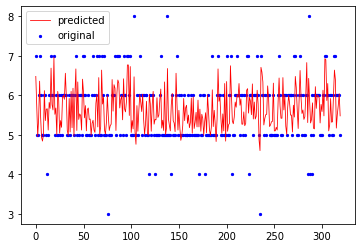

In [24]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()

到目前为止，我们在测试集上计算得到了$R^2$和$\hat{\text{SE}}$。那么，从这几个数字看来，随机森林回归模型的表现是不是已经足够好，符合我们的预期了呢？

In [25]:
from sklearn.ensemble import AdaBoostRegressor

In [26]:
?AdaBoostRegressor

In [27]:
abreg = AdaBoostRegressor()

In [28]:
params = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01, 0.05, 0.1, 0.5],
 'loss' : ['linear', 'square', 'exponential']
 }

In [29]:
clf = GridSearchCV(abreg, params, cv=10, return_train_score=True)
clf.fit(X_train_scaled, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0,
                                         loss='linear', n_estimators=50,
                                         random_state=None),
             iid='deprecated', n_jobs=None,
             param_grid={'learning_rate': [0.01, 0.05, 0.1, 0.5],
                         'loss': ['linear', 'square', 'exponential'],
                         'n_estimators': [50, 100]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
             scoring=None, verbose=0)

In [31]:
print(clf.best_params_)

{'learning_rate': 0.5, 'loss': 'linear', 'n_estimators': 100}


In [32]:
best_estim = clf.best_estimator_

In [33]:
y_pred = best_estim.predict(X_test_scaled)

In [34]:
mse = mean_squared_error(y_test, y_pred)

In [35]:
r2 = r2_score(y_test, y_pred)

In [36]:
print(f"Mean Squared Error: {mse:.3}")

Mean Squared Error: 0.454


In [37]:
print(f"R-Square: {r2:.3}")

R-Square: 0.297


最后，我们可以绘图看看结果：

In [38]:
%matplotlib inline
import matplotlib.pyplot as plt

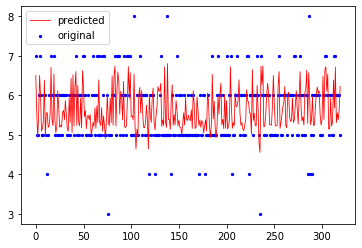

In [39]:
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred, lw=0.8, color="red", label="predicted")
plt.legend()
plt.show()